# Importing

In [2]:
%matplotlib notebook

import os
import sys
import time, datetime
import numpy as np
import matplotlib as mpl
import scipy.optimize as spy

from collections import OrderedDict
from importlib import reload
from matplotlib import pyplot as plt

sys.path.append(r"/Users/wgz/OneDrive/Experiments/BF3/Code")

import qcodes as qc
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import DataSet, load_by_id
from qcodes.dataset.database import initialise_database, get_DB_location
from pytopo.sweep import sweep, nest, chain, szip, getter, setter
#from qcodes.sweep.sweep import ParameterSweep, Nest, ParameterWrapper, FunctionWrapper, FunctionSweep, getter
#from pytopo.qctools import instruments as instools

from qcodes.dataset.data_export import get_shaped_data_by_runid, get_data_by_id
from qcodes.dataset.data_set import load_by_id

import scipy.optimize as optimize
import scipy.integrate as integrate
import scipy.fftpack as fft
import scipy.interpolate as interp
from scipy import stats
import re
#import spyview_data_import as data_import
from matplotlib.patches import Rectangle
import matplotlib.cm as cm
import matplotlib.colors as colors

In [3]:
qc.config["core"]["db_location"] = 'C:/Users/Alberto/Desktop/Q0243/Data/experiments_2019-04-11.db'
# automatically uses a different DB file for each month
initialise_database()
# creates a new DB file if nonexistant; leaves it untouched if file already exists

In [4]:
m = 9.11e-31
h = 6.623e-34
hbar = h/(2*np.pi)
e = 1.60217662e-19
G0 = 2*e**2/h

# Load data file and list parameters

In [5]:
dat1 = load_by_id(8)
R_s = 13.4e3 # series R in Ohm
V_bias = 10e-3 #bias voltage in V
exc = 10e-6
dat1.get_parameters()

[ParamSpec('field_sweep', 'numeric', 'field_sweep', 'T', inferred_from=[], depends_on=[]),
 ParamSpec('B_x', 'numeric', 'B_x', 'T', inferred_from=[], depends_on=['field_sweep']),
 ParamSpec('Lockin1_excitation', 'numeric', 'Lockin1_excitation', 'A', inferred_from=[], depends_on=['field_sweep']),
 ParamSpec('V_xx', 'numeric', 'V_xx', 'V', inferred_from=[], depends_on=['field_sweep']),
 ParamSpec('g_xx', 'numeric', 'g_xx', '2e^2/h', inferred_from=[], depends_on=['field_sweep']),
 ParamSpec('g_xy_j1', 'numeric', 'g_xy_j1', '2e^2/h', inferred_from=[], depends_on=['field_sweep']),
 ParamSpec('g_xy_j2', 'numeric', 'g_xy_j2', '2e^2/h', inferred_from=[], depends_on=['field_sweep']),
 ParamSpec('g_j1j2', 'numeric', 'g_j1j2', '2e^2/h', inferred_from=[], depends_on=['field_sweep']),
 ParamSpec('R_xx', 'numeric', 'R_xx', 'Ohm', inferred_from=[], depends_on=['field_sweep']),
 ParamSpec('R_xy_j1', 'numeric', 'R_xy_j1', 'Ohm', inferred_from=[], depends_on=['field_sweep']),
 ParamSpec('R_xy_j2', 'nume

In [6]:
w = 190e-9 # A
height_wire = 100e-9 # or "thickness", in usual 2D Hall language
length_SD = 3.45e-6 # length from source to drain
L_xx = 1.96e-6 # length between two xx leads (L1 and L2 in this case)

average R_xx = 1550.0803984701658
Fit std err j2 = 2.6954126478917977
Fitted slope j2 = -230.89724739455747
mobility from j2 = 15000 [cm^2 / (V*s)]



<IPython.core.display.Javascript object>


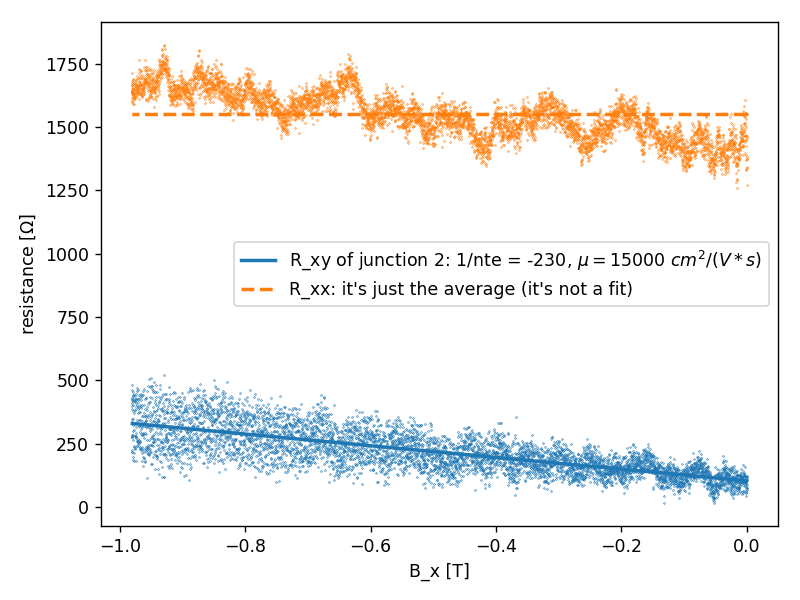

Text(0.5, 0, 'B_x [T]')

In [7]:
dat_HB2 = load_by_id(8)
VG = 1
R_xx = np.array(dat_HB2.get_values('R_xx'))[:,0]
average_R_xx = np.average(R_xx)
print('average R_xx =', average_R_xx)
#R_xy_j1 = np.array(dat_HB2.get_values('R_xy_j1'))[:,0]
R_xy_j2 = np.array(dat_HB2.get_values('R_xy_j2'))[:,0]
B_x = np.array(dat_HB2.get_values('B_x'))[:,0]
#nte_inverse1, intercept1, nte_fit_rval1, p_value1, nte_fit_std_err1 = stats.linregress(B_x, R_xy_j1)
nte_inverse2, intercept2, nte_fit_rval2, p_value2, nte_fit_std_err2 = stats.linregress(B_x, R_xy_j2)
#print('Fit std err j1 =', nte_fit_std_err1)
#print('Fitted slope j1 =', nte_inverse1)
#mu1 = np.abs(L_xx * nte_inverse1 / average_R_xx / w)
#round_mu1 = np.round(mu1, decimals=1)
#print('mobility from j1 = {} [cm^2 / (V*s)]\n'.format(int(round_mu1*1e4)))
print('Fit std err j2 =', nte_fit_std_err2)
print('Fitted slope j2 =', nte_inverse2)
mu2 = np.abs(L_xx * nte_inverse2 / average_R_xx / w)
round_mu2 = np.round(mu2, decimals=1)
print('mobility from j2 = {} [cm^2 / (V*s)]\n'.format(int(round_mu2*1e4)))

plt.figure('visualize linear fit').set_tight_layout(True)
#plt.scatter(B_x, R_xy_j1, s=0.1)
plt.scatter(B_x, R_xy_j2, s=0.1)
plt.scatter(B_x, R_xx, s=0.1)
#plt.plot(B_x, intercept1 + nte_inverse1*B_x, linewidth=2, label=r'R_xy of junction 1: 1/nte = {}, $\mu =${} $cm^2 / (V*s)$'.format(int(nte_inverse1), int(round_mu1*1e4)))
plt.plot(B_x, intercept2 + nte_inverse2*B_x, linewidth=2, label=r'R_xy of junction 2: 1/nte = {}, $\mu =${} $cm^2 / (V*s)$'.format(int(nte_inverse2), int(round_mu2*1e4)))
plt.plot(B_x, average_R_xx*np.ones(len(B_x)), '--', linewidth=2, label='R_xx: it\'s just the average (it\'s not a fit)')
plt.legend()
plt.ylabel('resistance [$\Omega$]')
plt.xlabel('B_x [T]')

In [10]:
nte_inverse, intercept, nte_fit_rval, p_value, nte_fit_std_err = stats.linregress(B_x, R_xy_j2)

In [122]:
B_x

array([-1.640000e-05, -1.350000e-05, -2.740000e-05, ..., -9.800907e-01,
       -9.800874e-01, -9.800985e-01])

In [123]:
dat_HB2.get_values('R_xy_j2')

[[76.6486091906221],
 [68.490220885346],
 [111.629085233477],
 [118.267551461],
 [105.299072727212],
 [122.981540985888],
 [87.8669499987902],
 [72.7504577869616],
 [53.8565318377922],
 [41.8715260237856],
 [73.2913726932414],
 [98.2001534489546],
 [119.447727502337],
 [93.2939478908189],
 [91.9126171906176],
 [94.9949233690501],
 [124.047710439368],
 [64.3260848953538],
 [58.0228953789379],
 [108.535602210274],
 [121.157634500184],
 [80.7300308949137],
 [83.7095215332602],
 [103.151066359171],
 [98.4236759983597],
 [98.0079303097066],
 [103.381289325038],
 [122.679787675091],
 [158.523047405408],
 [129.465783912782],
 [94.0472085077336],
 [63.2755544939512],
 [101.939605125678],
 [130.227968945312],
 [132.657598942762],
 [112.659500164493],
 [122.599311599545],
 [126.88638570501],
 [95.8912233538231],
 [85.2942593164804],
 [106.23114143145],
 [140.0493329022],
 [164.620598725652],
 [119.718188510978],
 [64.7552456319315],
 [54.4823814749257],
 [108.752417235217],
 [99.7312523574779],
